In [1]:
from itertools import product, permutations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotnine as gg
from tqdm import tqdm

from CurlingDB import CurlingDB
from utils.PlotnineElements import PlotnineElements as pe, blank
import utils.position_fetching as pf

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
db = CurlingDB(db_name='world_curling_ss.db')

In [4]:
# All values in m
circles = [0.152, 0.610, 1.219, 1.829]
pixel_to_m = 0.007370759
ice_width = [-4.75/2, 4.75/2]
ice_length = [-2, 6.401]
stone_radius = 14.5

# Circle values
inc = np.pi / 16
circle_range_x = np.cos(np.arange(0, 2 * np.pi + inc, inc))
circle_range_y = np.sin(np.arange(0, 2 * np.pi + inc, inc))

# Exploring all empty positions and the next throw

In [5]:
# Select all positions with no stones, get the throw type, position, winner of the end and match
first_throw_result_query = """
SELECT
    p.position_id,
    s.stone_id,
    s.x,
    s.y,
    s.size,
    t.type,
    CASE
        WHEN
            t.colour = 'red'
        THEN
            'team1'
        WHEN
            t.colour = 'yellow'
        THEN
            'team2'
        ELSE
            'unknown'
        END,
    CASE
        WHEN
            m.team_1_final_score > m.team_2_final_score
        THEN
            'team1'
        WHEN
            m.team_1_final_score < m.team_2_final_score
        THEN
            'team2'
        ELSE
            'draw'
        END,
    CASE 
		WHEN
			(e.team_1_final_score - COALESCE(LAG(e.team_1_final_score, 1)  OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - 
			e.team_2_final_score - COALESCE(LAG(e.team_2_final_score, 1)  OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) > 0
		THEN
			'team1'
		WHEN
			(e.team_1_final_score - COALESCE(LAG(e.team_1_final_score, 1)  OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - 
			e.team_2_final_score - COALESCE(LAG(e.team_2_final_score, 1)  OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) < 0
		THEN
			'team2'
		ELSE
			'blank'
		END
FROM 
    Stone s
JOIN
    Position p
ON
    s.position_id = p.position_id
JOIN
    End e
ON
    p.end_id = e.end_id
JOIN
    Throw t
ON
    e.end_id = t.end_id
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN
    Event e2
ON
    m.event_id = e2.event_id
JOIN
    (SELECT
        e.end_id AS end_id,
        p.frame_num + 1 AS frame_num,
        COUNT(*)
    FROM 
        Position p
    LEFT JOIN
        Stone s
    ON
        s.position_id = p.position_id
    JOIN
        End e
    ON
        p.end_id = e.end_id
    JOIN
        Match m
    ON
        e.match_id = m.match_id
    JOIN
        Event e2
    ON
        m.event_id = e2.event_id
    WHERE
        m.type IN ('Mens_Teams', 'Womens_Teams')
    AND
        x IS NULL
    GROUP BY
        1, 2) sub
ON
    p.frame_num = sub.frame_num AND e.end_id = sub.end_id
"""
db.execute_command(first_throw_result_query)
results = pd.DataFrame(db.cursor.fetchall(), columns=['pos', 'stone_id', 'x', 'y', 'size', 'type', 'throw_team', 'match_win', 'end_win'])
results

pos  stone_id         x         y  size                 type  \
0            3         1  1.757926  1.245658    40                 Draw   
1            3         1  1.757926  1.245658    40                 Draw   
2            3         1  1.757926  1.245658    40                 Draw   
3            3         1  1.757926  1.245658    40                 Draw   
4            3         1  1.757926  1.245658    40                Front   
...        ...       ...       ...       ...   ...                  ...   
212345  273026   1053146  0.187954  5.299576    46             Clearing   
212346  273026   1053146  0.187954  5.299576    46             Clearing   
212347  273026   1053146  0.187954  5.299576    46      Double Take-out   
212348  273026   1053146  0.187954  5.299576    46              Through   
212349  273026   1053146  0.187954  5.299576    46  Wick / Soft Peeling   

       throw_team match_win end_win  
0           team1     team1   team2  
1           team1     team1   team2  
2           team1     team1   team2  
3           team1     team1   team2  
4           team1     team1   team2  
...           ...       ...     ...  
212345      team2     team1   team2  
212346      team2     team1   team2  
212347      team2     team1   team2  
212348      team2     team1   team2  
212349      team2     team1   team2  

[212350 rows x 9 columns]

In [6]:
# Convert the match and end win columns to indicate whether the thrower won or not
results['match_win'] = results.apply(lambda x: 1 if x.match_win == x.throw_team else 0, axis=1)
results['end_win'] = results.apply(lambda x: 1 if x.end_win == x.throw_team else 0, axis=1)

In [7]:
results.groupby(['type']).agg({'end_win': ('mean', 'count')}).sort_values(by=[('end_win', 'mean')], ascending=False)

end_win       
                         mean  count
type                                
Guard                0.478265  11571
Wick / Soft Peeling  0.467094   2340
Double Take-out      0.455502  11124
Front                0.450629  21774
Raise                0.449047   5721
Freeze               0.444079   1520
Clearing             0.442862  20643
Promotion Take-out   0.438117   5268
Draw                 0.438065  64406
through              0.428571     56
Hit and Roll         0.418435  16024
no statistics        0.397489   5336
not played           0.384615     13
Take-out             0.373807  45066
Through              0.349338   1208

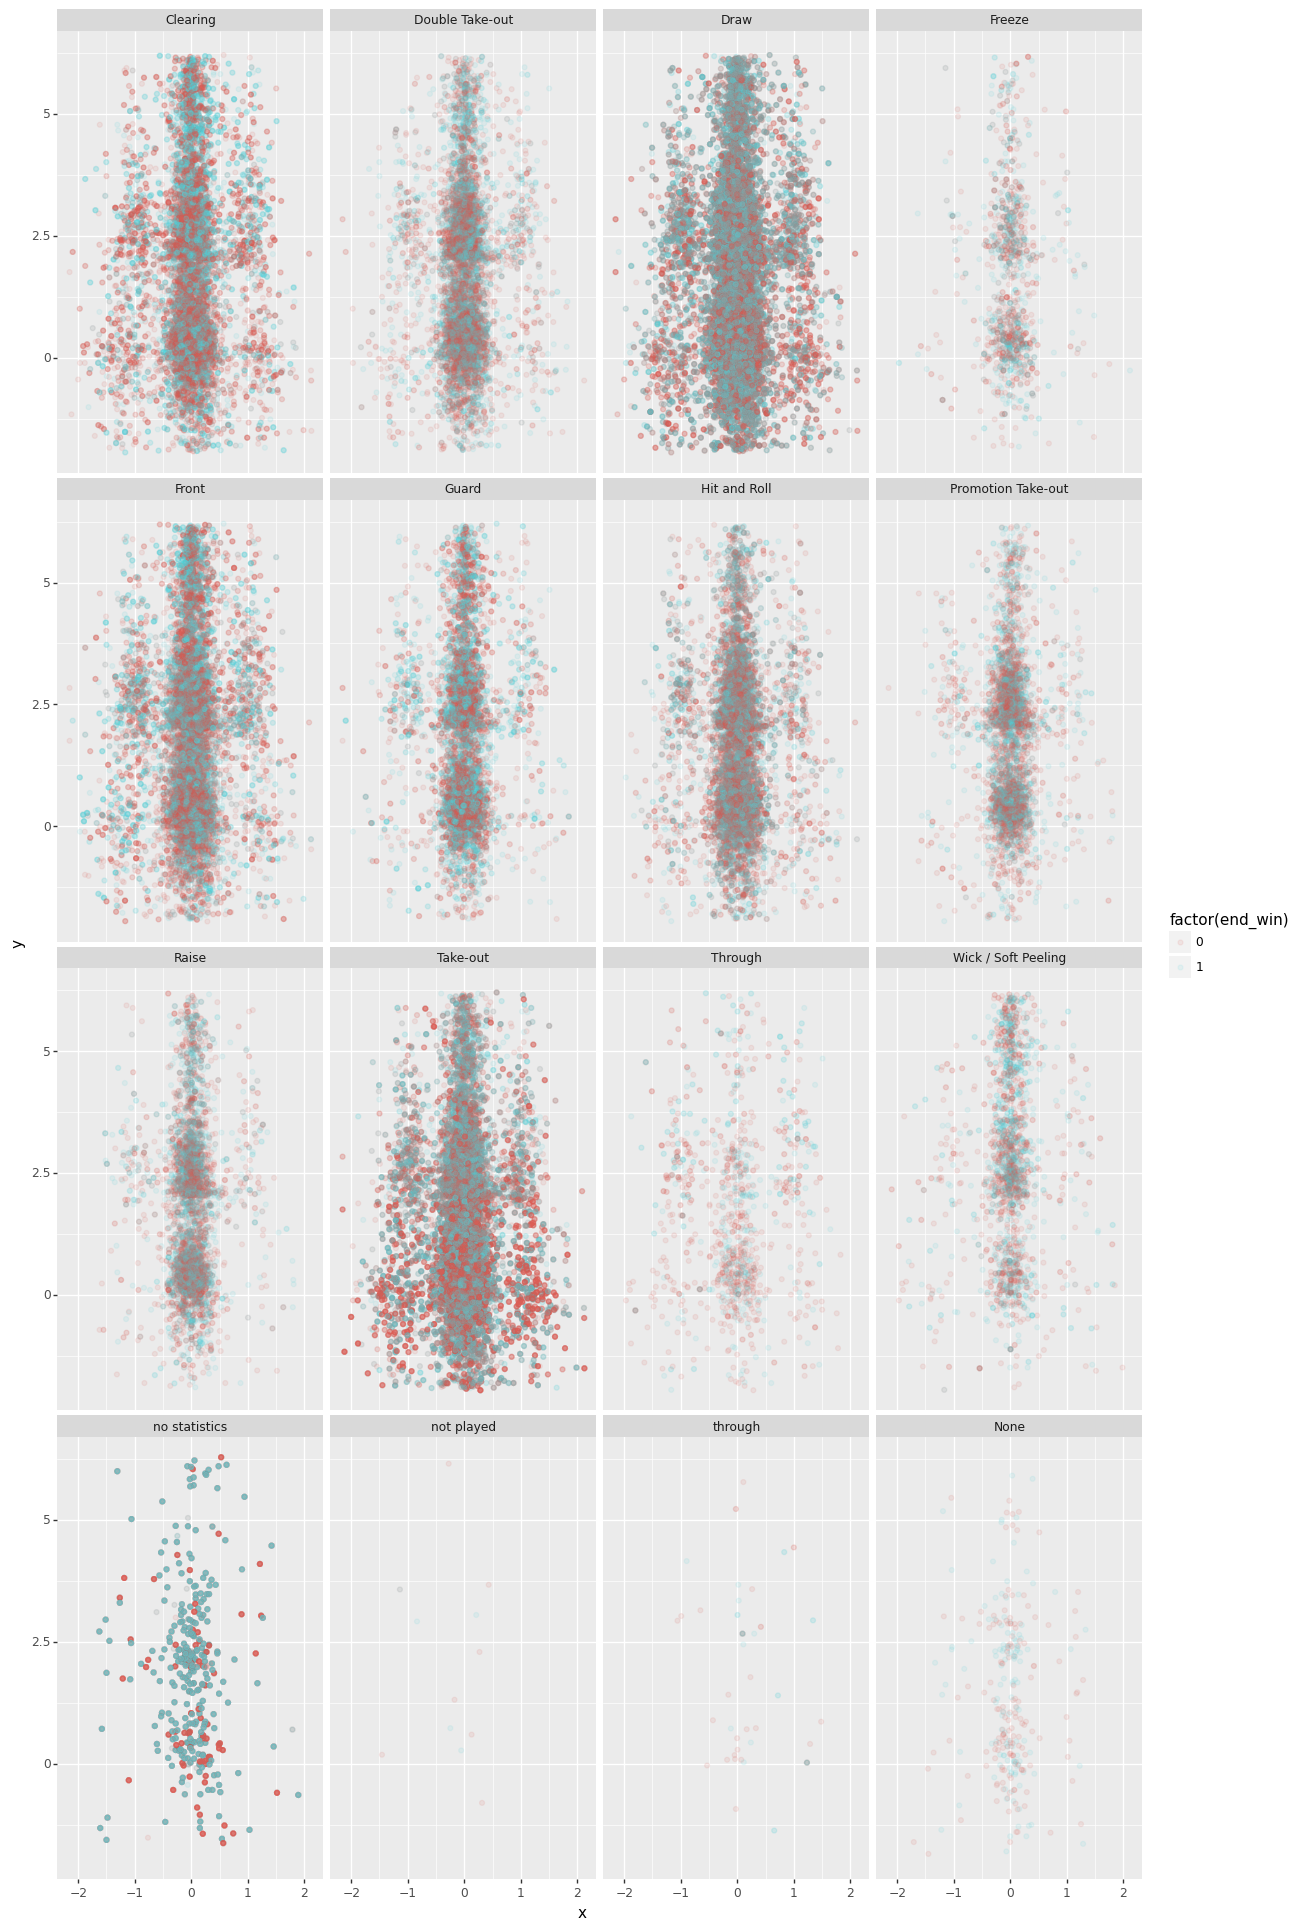

<ggplot: (702439593)>

In [8]:
(gg.ggplot(results, gg.aes(x='x', y='y', colour='factor(end_win)')) 
    + gg.geom_point(alpha=0.1) 
    + gg.facet_wrap('type')
    + gg.theme(figure_size=(14, 1.5 * len(results['type'].unique()))))

# Exploring Positions similar to a given one

## Given a position number, Get the lists of stones from the perspective of the team about to throw

In [24]:
# Getting the stone locations for a single position
# - I will flip the throwing team to represent the perspective of the person facing the position, this is opposite of the throw aligned with the stones
# - Therefore throw_team is the team that is facing the position
position_to_match = 3
stones_query = """
SELECT
    s.stone_id,
    CASE
        WHEN
            s.colour = 'red'
        THEN
            'team1'
        WHEN
            s.colour = 'yellow'
        THEN
            'team2'
        ELSE
            'unknown'
        END,
    s.x,
    s.y,
    CASE
        WHEN
            t.colour = 'red'
        THEN
            'team2'
        WHEN
            t.colour = 'yellow'
        THEN
            'team1'
        ELSE
            'unknown'
        END
FROM 
    Stone s
JOIN
    Position p
ON
    s.position_id = p.position_id
JOIN
    End e
ON
    p.end_id = e.end_id
JOIN
    Throw t
ON
    e.end_id = t.end_id AND p.frame_num = t.throw_num
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN
    Event e2
ON
    m.event_id = e2.event_id
WHERE p.position_id = ?
"""
db.execute_command(stones_query, (position_to_match,))
example_stones = pd.DataFrame(db.cursor.fetchall(), columns=['s_id', 'stone_team', 'x', 'y', 'throw_team'])
print(example_stones.shape)
thrower_points = example_stones.query('stone_team == throw_team')[['x', 'y']].values
non_thrower_points = example_stones.query('stone_team != throw_team')[['x', 'y']].values

thrower_count = len(thrower_points)
non_thrower_count = len(non_thrower_points)
total_count = thrower_count + non_thrower_count
print(f"Thrower: {thrower_count}\nNon-thrower: {non_thrower_count}\nTotal: {total_count}")

(1, 5)
Thrower: 0
Non-thrower: 1
Total: 1


In [5]:
# Get the target positions
thrower_targets, non_thrower_targets, stone_counts = pf.position_stones(db, 22)
print(f"Thrower: {stone_counts[0]}\nNon-thrower: {stone_counts[1]}\nTotal: {stone_counts[2]}")

Thrower: 2
Non-thrower: 1
Total: 3


## Given the stone lists, Find similar positions by the stone count

In [10]:
# Select all stones from positions that have the right number of stones
first_throw_result_query = """
SELECT
    p.position_id,
    p.next_pos,
    p.frame_num,
    s.stone_id,
    CASE
        WHEN
            s.colour = 'red'
        THEN
            'team1'
        WHEN
            s.colour = 'yellow'
        THEN
            'team2'
        ELSE
            'unknown'
        END,
    s.x,
    s.y,
    s.size,
    t.type,
    CASE
        WHEN
            t.colour = 'red'
        THEN
            'team2'
        WHEN
            t.colour = 'yellow'
        THEN
            'team1'
        ELSE
            'unknown'
        END,
    CASE
        WHEN
            m.team_1_final_score > m.team_2_final_score
        THEN
            'team1'
        WHEN
            m.team_1_final_score < m.team_2_final_score
        THEN
            'team2'
        ELSE
            'draw'
        END,
    CASE 
		WHEN
			(e.team_1_final_score - COALESCE(LAG(e.team_1_final_score, 1)  OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - 
			e.team_2_final_score - COALESCE(LAG(e.team_2_final_score, 1)  OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) > 0
		THEN
			'team1'
		WHEN
			(e.team_1_final_score - COALESCE(LAG(e.team_1_final_score, 1)  OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - 
			e.team_2_final_score - COALESCE(LAG(e.team_2_final_score, 1)  OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) < 0
		THEN
			'team2'
		ELSE
			'blank'
		END
FROM 
    Stone s
JOIN
    (SELECT
        *,
        LEAD(position_id, 1) OVER (PARTITION BY end_id ORDER BY frame_num) AS next_pos
    FROM
        Position) p
ON
    s.position_id = p.position_id
JOIN
    End e
ON
    p.end_id = e.end_id
JOIN
    Throw t
ON
    e.end_id = t.end_id AND p.frame_num = t.throw_num
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN
    Event e2
ON
    m.event_id = e2.event_id
JOIN
    (SELECT
        p.position_id,
        e.end_id,
        p.frame_num AS frame_num,
        COUNT(*)
    FROM 
        Position p
    JOIN
        Stone s
    ON
        s.position_id = p.position_id
    JOIN
        End e
    ON
        p.end_id = e.end_id
    JOIN
        Throw t
    ON
        e.end_id = t.end_id AND p.frame_num = t.throw_num
    JOIN
        Match m
    ON
        e.match_id = m.match_id
    JOIN
        Event e2
    ON
        m.event_id = e2.event_id
    GROUP BY
        1
    HAVING
        COUNT(*) = ? AND
        COUNT(CASE WHEN s.colour != t.colour THEN 1 ELSE NULL END) = ? AND
        COUNT(CASE WHEN s.colour = t.colour THEN 1 ELSE NULL END) = ?
    ) sub
ON 
    p.frame_num = sub.frame_num AND e.end_id = sub.end_id
"""
# Looking for positions with 3 stones, 1 from throwing team and 2 from non-throwing team
# - Also removing any last frame positions
db.execute_command(first_throw_result_query, (total_count, thrower_count, non_thrower_count))
positions = pd.DataFrame(db.cursor.fetchall(), columns=['pos', 'next_pos', 'frame_num', 'stone_id', 'stone_team', 'x', 'y', 'size', 'type', 'throw_team', 'match_win', 'end_win']).dropna()
print(positions.shape)
positions.head(10)

(54813, 12)


pos  next_pos  frame_num  stone_id stone_team         x         y  size  \
0    6       7.0          5         8      team1 -0.954513 -1.798465    64   
1    6       7.0          5         7      team1  1.765297  1.238288    52   
2    6       7.0          5         9      team2  0.128988 -1.378332    58   
3   21      22.0          3        99      team1  1.238288  3.891761    64   
4   21      22.0          3       101      team2 -0.552807  1.253029    64   
5   21      22.0          3       100      team2 -0.287460 -0.493841    40   
6   22      23.0          4       103      team1  1.241973  3.891761    64   
7   22      23.0          4       102      team1  1.352534  0.051595    40   
8   22      23.0          4       104      team2 -0.556492  1.253029    64   
9   38      39.0          3       199      team1 -0.810783 -1.282512    64   

       type throw_team match_win end_win  
0  Take-out      team1     team1   team2  
1  Take-out      team1     team1   team2  
2  Take-out      team1     team1   team2  
3      Draw      team2     team1   team2  
4      Draw      team2     team1   team2  
5      Draw      team2     team1   team2  
6      Draw      team1     team1   team2  
7      Draw      team1     team1   team2  
8      Draw      team1     team1   team2  
9      Draw      team1     team1   team2

## Process the distances from each position to the target

In [11]:
def add_scores(positions: pd.DataFrame, thrower_locations, non_thrower_locations):
    pos_scores = []

    for pos, group in tqdm(positions.groupby('pos')):

        # Collect stone positions for each team
        throwing_team = group.iloc[0]['throw_team']
        pos_thrower_stones = group.query('stone_team == @throwing_team')[['x', 'y']].values
        pos_non_thrower_stones = group.query('stone_team != @throwing_team')[['x', 'y']].values

        pos_score = 0
        max_stone_score = 0
        for points, stones in [(non_thrower_points, pos_non_thrower_stones), (thrower_locations, pos_thrower_stones)]:
            N = len(points)
            if N == 0: 
                # No stones, no loss
                continue
            elif N == 1:
                # Handle the single stone case, single permutation
                pos_score += (((points - stones)**2).sum())**(1/2)
                max_stone_score = (((points - stones)**2).sum())**(1/2) if (((points - stones)**2).sum())**(1/2) > max_stone_score else max_stone_score
                continue

            # Create the matrix of distance between each of the points
            indices = list(zip(*[x for x in product(range(2*N), range(2*N)) if (sum(x) % 2)]))
            grid = np.subtract.outer(stones.ravel(), points.ravel())
            grid[indices[0], indices[1]] = 0  # Zero out the x-y operations
            grid_sum = (grid**2).reshape(N, 2, N, 2).sum(axis=1).sum(axis=-1)**(1/2) # Element-wise square, sum along axes to reduce, and then element-wise sqrt

            # Find the best permutation of the elements
            # This will be used to determine if the position is a match, match-ness described by the distance
            # Alternatively, you could just loop over stones in the actual position and check if there are other stones within their radius but
            #   I am not totally sure this would work as it would depend on the parsing order of the stones.
            # - Another idea to implement is a partial match where only the house or only a certain slice of the ice is considered
            #   - This would have to be implemented earlier and likely in SQL if I don't want to pull all the data
            
            # Create list of permutations
            perms = list(permutations(range(N), N))
            # Get the 'loss' for each permutation of stone-stone matching and add to running sum
            losses = grid_sum[range(N), np.array(perms)].sum(-1)
            pos_score += losses.min()
            # Get the stone order for the closest match and then the maximum stone score(farthest stone from target)
            stone_order = perms[losses.argmin()] 
            max_stone_score = grid_sum[range(N), stone_order].max() if grid_sum[range(N), stone_order].max() > max_stone_score else max_stone_score

        pos_scores.append((pos, pos_score, max_stone_score))
    
    return pos_scores

scores = add_scores(positions, thrower_points, non_thrower_points)
scores_df = pd.DataFrame(scores, columns=['pos', 'score', 'max_stone_score'])
positions = positions.merge(scores_df, on='pos')

100%|██████████| 18271/18271 [00:26<00:00, 679.68it/s]


## Analyze results of comparison to target

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10


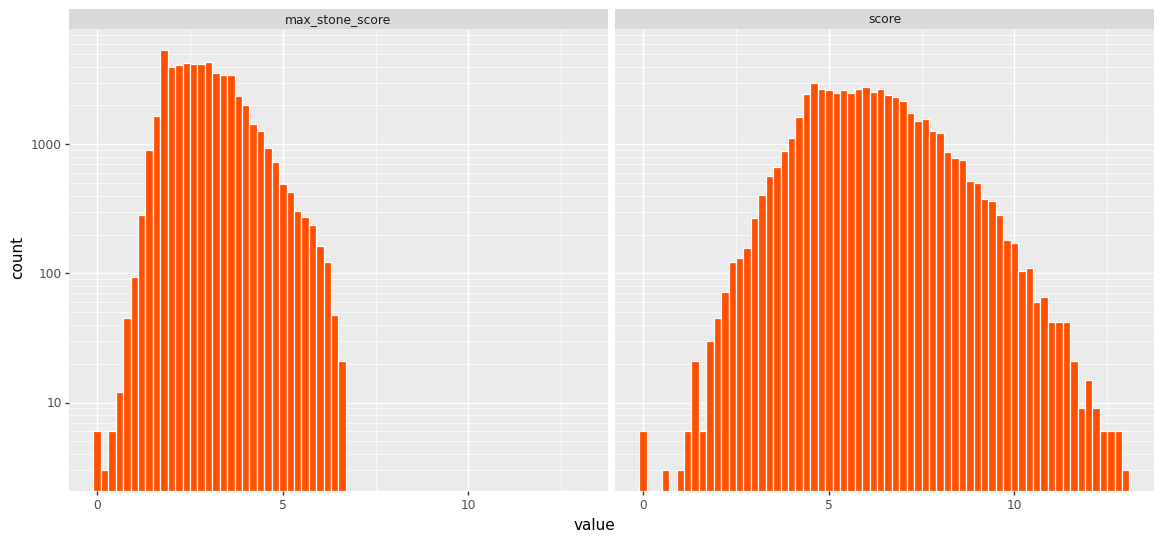

<ggplot: (686312714)>

In [8]:
(gg.ggplot(positions[['pos', 'score', 'max_stone_score']].melt(id_vars='pos', value_vars=['score', 'max_stone_score']), gg.aes(x='value'))
    + gg.geom_histogram(binwidth=0.2, fill='#ff4f00', colour='#ffffff')
    + gg.facet_grid('. ~ variable')
    + gg.scale_y_log10()
    + gg.theme(figure_size=(14, 6))
    )

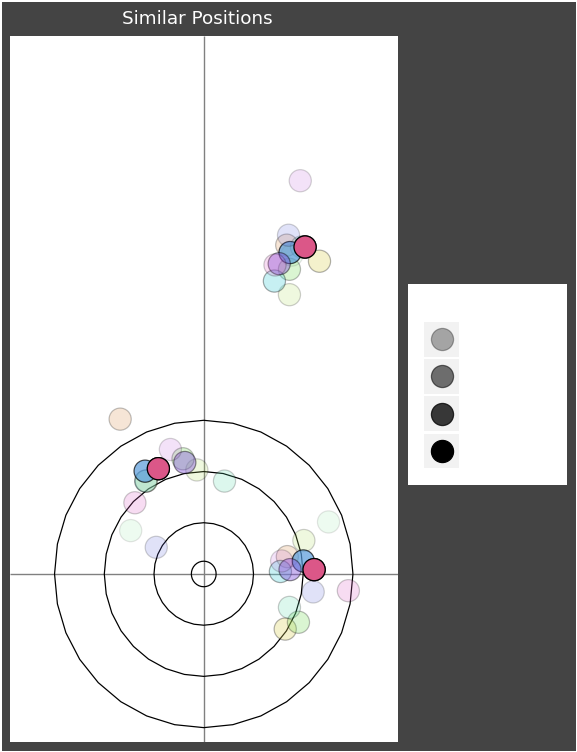

<ggplot: (686434847)>

In [9]:
size = 5
score_threshold = 1.6
(gg.ggplot(positions.query('score < @score_threshold'), gg.aes(x='x', y='y', fill='factor(pos)', alpha='-score'))
    + gg.annotate(geom='path', x=circles[0] * circle_range_x, y=circles[0] * circle_range_y)
    + gg.annotate(geom='path', x=circles[1] * circle_range_x, y=circles[1] * circle_range_y)
    + gg.annotate(geom='path', x=circles[2] * circle_range_x, y=circles[2] * circle_range_y)
    + gg.annotate(geom='path', x=circles[3] * circle_range_x, y=circles[3] * circle_range_y)

    + gg.geom_point(size=8.5)

    + gg.scale_x_continuous(limits=ice_width, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_y_continuous(limits=ice_length, expand=(0, 0), breaks=lambda x: [0])
    # + gg.scale_fill_manual(values=['red', 'yellow'], guide=False) # make fill='factor(team)'
    + gg.scale_fill_discrete(guide=False) # make fill='factor(team)'

    + gg.theme(figure_size=(size, size * ((800 + 300)/(600))))
    + gg.theme(panel_grid=gg.element_line(colour='gray'))
    + gg.theme(text=gg.element_text(colour='white'))
    + gg.theme(axis_text=blank, axis_title_x=blank, axis_title_y=blank, title=gg.element_text(text='Similar Positions'))
    + gg.theme(strip_text=gg.element_text(size=14), strip_background=blank)

    + pe.background_colour(panel_colour='#FFFFFF', plot_colour='#444444')
    + pe.remove_grid(minor=True)
    + pe.remove_ticks(minor=True, major=True)
    )

## Fetch all similar positions

In [14]:
# Now that I have all of these positions that are relatively similar
# - Find the positions that follow by finding the end_id and frame_num of the current ones and getting the next one
#   - From those positions get: 
#       - throw type(what to throw next), 
#       - throw rating(how hard it is to throw by averaging), 
#       - match_win, end_win(see if it was successful)
#       - frame_num(see if it is temporally dependent)

### Plot all positions

In [15]:
next_pos = positions.query('score < @score_threshold').next_pos.unique()
next_stones_query = """
SELECT
    p.position_id,
    p.frame_num,
    CASE
        WHEN
            s.colour = 'red'
        THEN
            'team1'
        WHEN
            s.colour = 'yellow'
        THEN
            'team2'
        ELSE
            'unknown'
        END,
    CASE WHEN s.size < 47 THEN (CASE WHEN s.colour == 'red' THEN 'pink' WHEN s.colour == 'yellow' THEN 'green' END)
        ELSE s.colour END AS label,
    s.x,
    s.y,
    s.size,
    t.type,
    CASE
        WHEN
            t.colour = 'red'
        THEN
            'team1'
        WHEN
            t.colour = 'yellow'
        THEN
            'team2'
        ELSE
            'unknown'
        END,
    CASE
        WHEN
            m.team_1_final_score > m.team_2_final_score
        THEN
            'team1'
        WHEN
            m.team_1_final_score < m.team_2_final_score
        THEN
            'team2'
        ELSE
            'draw'
        END,
    CASE 
		WHEN
			(e.team_1_final_score - COALESCE(LAG(e.team_1_final_score, 1)  OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - 
			e.team_2_final_score - COALESCE(LAG(e.team_2_final_score, 1)  OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) > 0
		THEN
			'team1'
		WHEN
			(e.team_1_final_score - COALESCE(LAG(e.team_1_final_score, 1)  OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - 
			e.team_2_final_score - COALESCE(LAG(e.team_2_final_score, 1)  OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) < 0
		THEN
			'team2'
		ELSE
			'blank'
		END
    
FROM 
    Stone s
JOIN
    Position p
ON
    s.position_id = p.position_id
JOIN
    End e
ON
    p.end_id = e.end_id
JOIN
    Throw t
ON
    e.end_id = t.end_id AND t.throw_num = p.frame_num
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN
    Event e2
ON
    m.event_id = e2.event_id
WHERE
    p.position_id IN (""" + ','.join('?' * len(next_pos)) + ')'
db.execute_command(next_stones_query, tuple(next_pos))
next_stones = pd.DataFrame(db.cursor.fetchall(), columns=['pos', 'frame_num', 'stone_team', 'colour', 'x', 'y', 'size', 'type', 'throw_team', 'match_win', 'end_win']).dropna()

# Filter to valid positions
valid_positions = next_stones.groupby('pos').count().query('stone_team < @total_count + 2').index.values
next_stones = next_stones.query('pos in @valid_positions')

print(next_stones.shape)
next_stones

(33, 11)


pos  frame_num stone_team  colour         x         y  size  \
5    21121         16      team1     red -1.028221  1.842690    64   
6    21121         16      team1    pink  0.114247 -0.287460    40   
7    21121         16      team2  yellow  1.020850  3.913873    64   
8    21121         16      team2  yellow  1.028221  0.199010    64   
9    27159         14      team1    pink -2.155947  0.022112    46   
10   27159         14      team1     red  0.998738 -0.655998    64   
11   27159         14      team1     red  1.418871  3.722233    52   
17   43078          9      team1     red -0.254291  1.370961    64   
18   43078          9      team1    pink  0.777615 -1.304624    46   
19   43078          9      team2  yellow  1.050333  3.626413    64   
20   43078          9      team2  yellow  1.183007 -0.582290    70   
21   52664          5      team1     red  1.079816  3.795941    64   
22   52664          5      team2  yellow -0.895547  0.515953    58   
23   52664          5      team2   green -0.593346 -0.965569    40   
24   80262          8      team1    pink  0.269033  1.348849    46   
25   80262          8      team1     red  1.050333 -0.398021    64   
26   80262          8      team1     red  1.197748  3.891761    64   
27   80619          8      team1    pink  0.858693  0.324313    40   
28   80619          8      team1     red  0.866064  3.486369    52   
29   80619          8      team1     red  0.939772  0.029483    58   
30   80619          8      team2  yellow -0.718649  1.112985    52   
31   94796          3      team1     red  1.057704  3.832795    64   
32   94796          3      team1     red  1.219861  0.154786    64   
33   94796          3      team2  yellow -0.718649  1.223546    58   
34   94796          3      team2   green  0.740761  0.884491    40   
35  132877          7      team1     red  1.042962  4.031805    64   
36  132877          7      team2  yellow -0.585975  0.316943    64   
37  195281          5      team1     red -0.232179  1.326737    64   
38  228213          8      team1     red  1.183007  4.680432    64   
39  228213          8      team1    pink  1.411500  0.125303    40   
40  228213          8      team2  yellow -0.409077  1.481523    64   
41  230331          5      team1     red  0.873435  3.678009    64   
42  230331          5      team2  yellow -0.843952  0.847637    64   

            type throw_team match_win end_win  
5           Draw      team2     team1   team1  
6           Draw      team2     team1   team2  
7           Draw      team2     team1   team2  
8           Draw      team2     team1   team2  
9       Take-out      team1     team2   team2  
10      Take-out      team1     team2   team2  
11      Take-out      team1     team2   team2  
17        Freeze      team2     team2   team2  
18        Freeze      team2     team2   team2  
19        Freeze      team2     team2   team2  
20        Freeze      team2     team2   team2  
21  Hit and Roll      team1     team1   blank  
22  Hit and Roll      team1     team1   team2  
23  Hit and Roll      team1     team1   team2  
24      Take-out      team1     team1   team1  
25      Take-out      team1     team1   team2  
26      Take-out      team1     team1   team2  
27          Draw      team1     team2   team1  
28          Draw      team1     team2   team2  
29          Draw      team1     team2   team2  
30          Draw      team1     team2   team2  
31          Draw      team1     team2   team2  
32          Draw      team1     team2   team2  
33          Draw      team1     team2   team2  
34          Draw      team1     team2   team2  
35      Take-out      team1     team2   team2  
36      Take-out      team1     team2   team2  
37          Draw      team2     team2   blank  
38          Draw      team1     team2   team2  
39          Draw      team1     team2   team2  
40          Draw      team1     team2   team2  
41      Take-out      team1     team2   team2  
42      Take-out      team1     team2   te

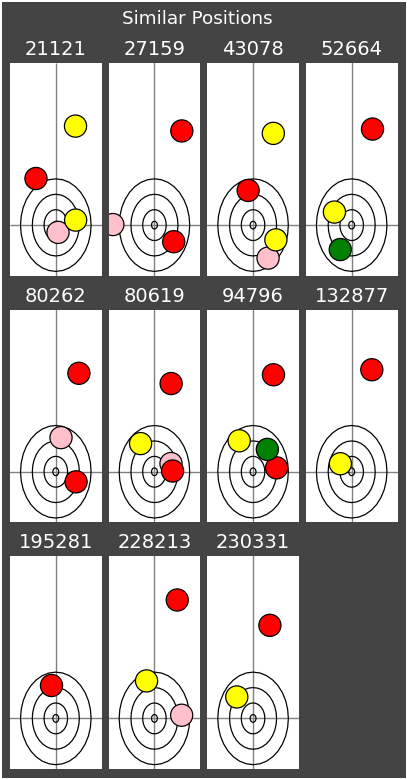

<ggplot: (686656543)>

In [11]:
(gg.ggplot(next_stones, gg.aes(x='x', y='y', fill='factor(colour)'))
    + gg.annotate(geom='path', x=circles[0] * circle_range_x, y=circles[0] * circle_range_y)
    + gg.annotate(geom='path', x=circles[1] * circle_range_x, y=circles[1] * circle_range_y)
    + gg.annotate(geom='path', x=circles[2] * circle_range_x, y=circles[2] * circle_range_y)
    + gg.annotate(geom='path', x=circles[3] * circle_range_x, y=circles[3] * circle_range_y)

    + gg.geom_point(size=8.5)

    + gg.facet_wrap('pos')

    + gg.scale_x_continuous(limits=ice_width, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_y_continuous(limits=ice_length, expand=(0, 0), breaks=lambda x: [0])
    # + gg.scale_fill_manual(values=['red', 'yellow'], guide=False) # make fill='factor(team)'
    + gg.scale_fill_manual(values=['green', 'pink', 'red', 'yellow'], guide=False)
    # + gg.scale_fill_discrete(guide=False) # make fill='factor(team)'

    + gg.theme(figure_size=(size, size * ((800 + 300)/(600))))
    + gg.theme(panel_grid=gg.element_line(colour='gray'))
    + gg.theme(text=gg.element_text(colour='white'))
    + gg.theme(axis_text=blank, axis_title_x=blank, axis_title_y=blank, title=gg.element_text(text='Similar Positions'))
    + gg.theme(strip_text=gg.element_text(size=14), strip_background=blank)

    + pe.background_colour(panel_colour='#FFFFFF', plot_colour='#444444')
    + pe.remove_grid(minor=True)
    + pe.remove_ticks(minor=True, major=True)
    )

### Position Stats

In [12]:
ind_pos = next_stones[['pos', 'frame_num', 'type', 'throw_team', 'match_win', 'end_win']].drop_duplicates()
ind_pos['thrower_win_match'] = ind_pos.apply(lambda x: 1 if x['throw_team'] == x['match_win'] else 0, axis=1)
ind_pos['thrower_win_end'] = ind_pos.apply(lambda x: 1 if x['throw_team'] == x['end_win'] else 0, axis=1)
ind_pos.drop(columns=['pos']).groupby(['type']).agg(['mean', 'count'])

/var/folders/zz/z3rhbf4x4hdb8gwyxnpw92_40000gn/T/ipykernel_52036/2919593829.py:4: FutureWarning: ['throw_team', 'match_win', 'end_win'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.


frame_num       thrower_win_match       thrower_win_end      
                  mean count              mean count            mean count
type                                                                      
Draw          9.142857     7          0.142857     7        0.285714     7
Freeze        9.000000     1          1.000000     1        1.000000     1
Hit and Roll  5.000000     2          1.000000     2        0.000000     2
Take-out      8.400000     5          0.400000     5        0.200000     5

# Consolidated fetching of similar positions

### Get information about positions

In [24]:
event = 'CUR_PACC2017B'
team_1 = 'NZL'
team_2 = 'AUS'
end = 4

pf.find_pos_id(db, event, team_1, team_2, end)

frame_num  position_id
0           0           52
1           1           53
2           2           54
3           3           55
4           4           56
5           5           57
6           6           58
7           7           59
8           8           60
9           9           61
10         10           62
11         11           63
12         12           64
13         13           65
14         14           66
15         15           67
16         16           68

### Fetch the positions that are similar to the target position

In [32]:
score_threshold = 0.8
positions, thrower_targets, non_thrower_targets, next_stones = pf.similar_positions(db, 54, score_threshold, include_inverse=True)

Finding positions with 1 thrower stones and 1 non-thrower stones.
Found 19567 positions with the same stone count.
Score calculated for all positions.
Found 92 positions with 265 stones.


/Users/lucasnieuwenhout/Documents/Programming/Python/Projects/curling/src/utils/position_fetching.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Plot the distributions of position distances

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 8 rows containing non-finite values.
/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10


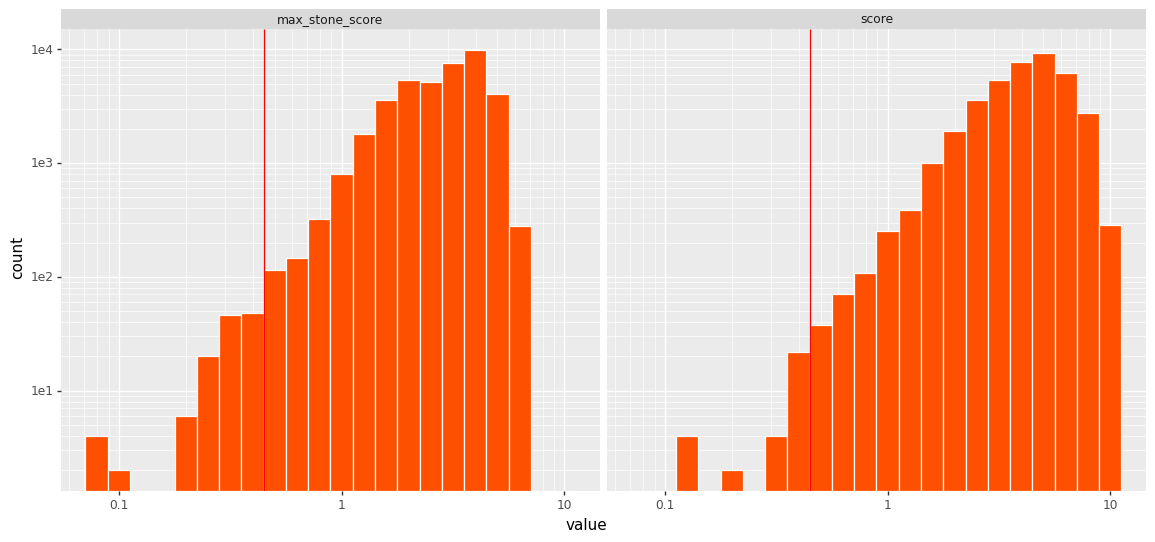

<ggplot: (677541642)>

In [28]:
(gg.ggplot(positions[['pos', 'score', 'max_stone_score']].melt(id_vars='pos', value_vars=['score', 'max_stone_score']), gg.aes(x='value'))
    + gg.geom_histogram(binwidth=0.1, fill='#ff4f00', colour='#ffffff')
    + gg.geom_vline(gg.aes(xintercept=score_threshold), colour='#ff0000')
    + gg.facet_grid('. ~ variable')

    + gg.scale_x_log10()
    + gg.scale_y_log10()
    + gg.theme(figure_size=(14, 6))
    )

### Plot the similar positions

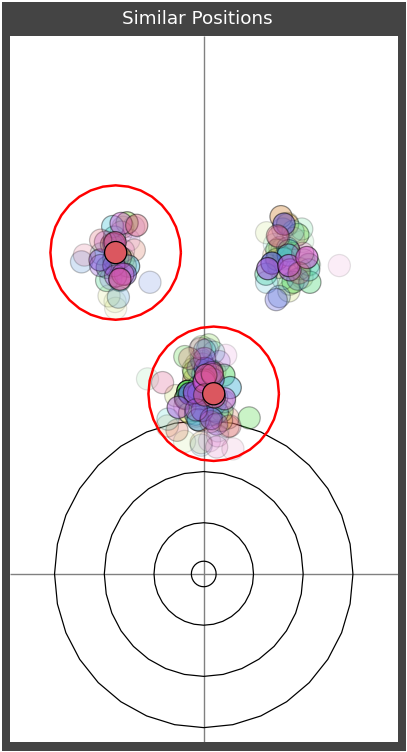

<ggplot: (714814145)>

In [33]:
size = 5
target_circles = [gg.annotate(geom='path', x=(score_threshold) * circle_range_x + z[0], y=(score_threshold) * circle_range_y + z[1], colour='red', size=1) for z in np.vstack((thrower_targets, non_thrower_targets))]
(gg.ggplot(positions.query('score < @score_threshold'), gg.aes(x='x', y='y', fill='factor(pos)', alpha='-score'))
    + gg.annotate(geom='path', x=circles[0] * circle_range_x, y=circles[0] * circle_range_y)
    + gg.annotate(geom='path', x=circles[1] * circle_range_x, y=circles[1] * circle_range_y)
    + gg.annotate(geom='path', x=circles[2] * circle_range_x, y=circles[2] * circle_range_y)
    + gg.annotate(geom='path', x=circles[3] * circle_range_x, y=circles[3] * circle_range_y)

    + gg.geom_point(size=8.5)

    + target_circles # Circles around targets indicating desired size

    + gg.scale_x_continuous(limits=ice_width, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_y_continuous(limits=ice_length, expand=(0, 0), breaks=lambda x: [0])
    # + gg.scale_fill_manual(values=['red', 'yellow'], guide=False) # make fill='factor(team)'
    + gg.scale_fill_discrete(guide=False)
    + gg.scale_alpha(guide=False)

    + gg.theme(figure_size=(size, size * ((800 + 300)/(600))))
    + gg.theme(panel_grid=gg.element_line(colour='gray'))
    + gg.theme(text=gg.element_text(colour='white'))
    + gg.theme(axis_text=blank, axis_title_x=blank, axis_title_y=blank, title=gg.element_text(text='Similar Positions'))
    + gg.theme(strip_text=gg.element_text(size=14), strip_background=blank)

    + pe.background_colour(panel_colour='#FFFFFF', plot_colour='#444444')
    + pe.remove_grid(minor=True)
    + pe.remove_ticks(minor=True, major=True)
    )

### Plot all of the follow-up positions

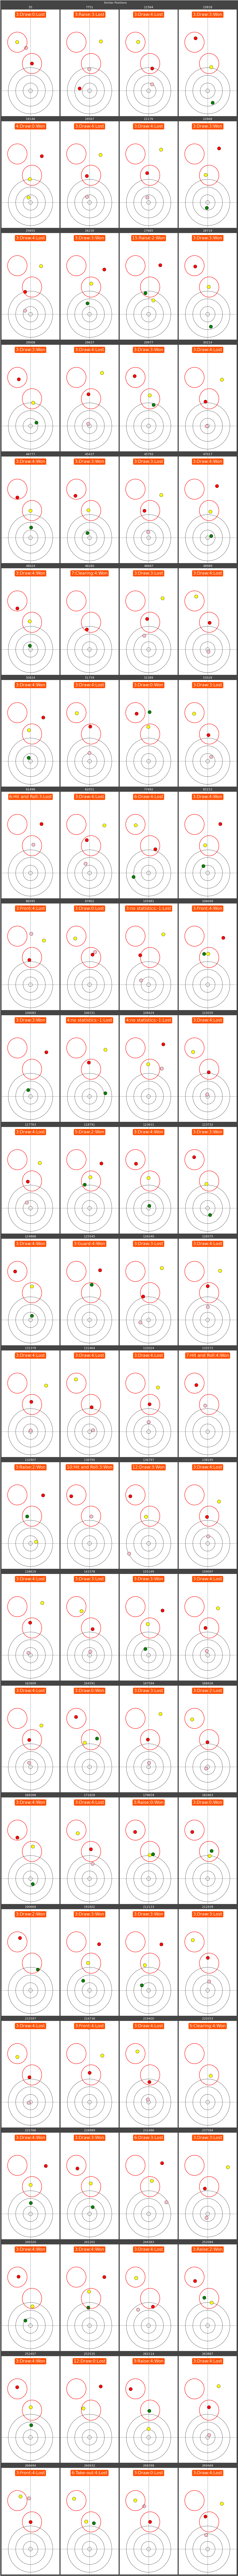

<ggplot: (699397765)>

In [34]:
from math import ceil
# facet_wrap with 6 columns
facet_nrow = 4
plot_size = (size * facet_nrow, (size * ((800 + 300) / (600))) * (len(next_stones.pos.unique()) // facet_nrow + 1))
(gg.ggplot(next_stones, gg.aes(x='x', y='y', fill='factor(colour)'))
    + gg.annotate(geom='path', x=circles[0] * circle_range_x, y=circles[0] * circle_range_y)
    + gg.annotate(geom='path', x=circles[1] * circle_range_x, y=circles[1] * circle_range_y)
    + gg.annotate(geom='path', x=circles[2] * circle_range_x, y=circles[2] * circle_range_y)
    + gg.annotate(geom='path', x=circles[3] * circle_range_x, y=circles[3] * circle_range_y)

    + gg.geom_point(size=8.5)

    + gg.geom_label(next_stones[['pos', 'plot_label']].drop_duplicates(), gg.aes(x=0, y=6, label='plot_label'), size=20, fill='#ff4f00', colour='#ffffff')

    + target_circles # Circles around targets indicating desired size

    + gg.facet_wrap('pos', ncol=facet_nrow)

    + gg.scale_x_continuous(limits=ice_width, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_y_continuous(limits=ice_length, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_fill_manual(values=['green', 'pink', 'red', 'yellow'], guide=False)

    + gg.theme(figure_size=plot_size)
    + gg.theme(panel_grid=gg.element_line(colour='gray'))
    + gg.theme(text=gg.element_text(colour='white'))
    + gg.theme(axis_text=blank, axis_title_x=blank, axis_title_y=blank, title=gg.element_text(text='Similar Positions'))
    + gg.theme(strip_text=gg.element_text(size=14), strip_background=blank)

    + pe.background_colour(panel_colour='#FFFFFF', plot_colour='#444444')
    + pe.remove_grid(minor=True)
    + pe.remove_ticks(minor=True, major=True)
    )

### Get some statistics on the position

In [51]:
# Best type of throw to win the end
next_stones['winning_throw'] = next_stones.apply(lambda x: 0.5 if x.end_win == 'blank' else 0 if x.throw_team == x.end_win else 1, axis=1)
next_stones.groupby(['type'])['winning_throw'].agg(['mean', 'count'])

mean  count
type                          
Clearing       0.000000      2
Draw           0.436620    213
Front          0.666667     12
Guard          0.500000      2
Hit and Roll   0.416667      6
Raise          0.111111     18
Take-out       0.833333      3
no statistics  0.888889      9